In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
control_df = pd.read_csv('./../../../Datasets/UKEssen/NSCLC_Non-Pembro_GENIE_13-05-2025.csv')
treat_df = pd.read_csv('./../../../Datasets/UKEssen/NSCLC_Pembro_MSKCHORD_13-05-2025.csv')


In [4]:
treat_df = treat_df.rename(columns={'TTF_Pembro': 'TTF',
    'TTF_Pembro_observed': 'TTF_observed',
    'PFS_Pembro': 'PFS',
    'PFS_Pembro_observed': 'PFS_observed',
    'OS_Pembro': 'OS',
    'OS_Pembro_observed': 'OS_observed'
})
merged_df = pd.concat([control_df, treat_df], ignore_index=True, sort=False)
merged_df = merged_df.rename(columns={'ICD-O Histology Description': 'Histopathology', 
                  'History for Positive PD-L1 (NLP)':'Pos_PD-L1',
                  'Smoking History (NLP)': 'Smoker'})

merged_df = merged_df.drop('Ethnicity', axis=1)

In [5]:
histo = set(list(merged_df['Histopathology']))

for h in histo:
    print(h)

Adenocarcinoma, Nos
Acinar Cell Carcinoma
Pseudosarcomatous Carcinoma
Carcinoma, Nos
Solid Carcinoma, Nos
nan
Squamous cell
Mucinous Adenocarcinoma
Squamous Cell Carcinoma, Nos
Acinar Cell Cystadenocarcinoma
Small cell carcinoma
Sq Cell Ca, Keratinizing Type, Nos
Bronchiolo-Alveolar Carcinoma, Mucinous (C34._)
Neuroendocrine Carcinoma
Other histologies/mixed tumor
Non-Small Cell Carcinoma (C34._)
Giant Cell & Spindle Cell Carcinoma
Sq Cell Ca, Large Cell, Non-Keratinizing
Papillary Adenocarcinoma, Nos
Bronchiolo-Alveolar Ca Mixed Muc/Non Mucinous (C34._)
Pleomorphic Carcinoma
Large Cell Neuroendocrine Carcinoma
Small Cell Carcinoma, Nos
Adenocarcinoma
Adenocarcinoma Combined With Other Types Of Carcinoma
Adenosquamous Carcinoma
Carcinoma
Mucin-Producing Adenocarinoma


In [7]:
merged_df['Histopathology'] = merged_df['Histopathology'].replace({
    'Squamous Cell Carcinoma, Nos': 'Squamous Cell',
    'Small cell carcinoma': 'Small Cell Carcinoma, Nos',
    'Carcinoma, Nos': 'Carcinoma',
    'Papillary Adenocarcinoma, Nos': 'Adenocarcinoma',
    'Mucin-Producing Adenocarinoma': 'Mucinous Adenocarcinoma',
    'Bronchiolo-Alveolar Ca Mixed Muc/Non Mucinous (C34._)': 'Bronchiolo-Alveolar Carcinoma, Mucinous (C34._)',
})

In [8]:
def group_histology(label):
    label = str(label).lower()
    
    if any(sub in label for sub in [
        'adenocarcinoma', 'acinar', 'mucin', 'bronchiolo'
    ]):
        return 'Adenocarcinoma'
    
    elif 'squamous' in label:
        return 'Squamous_Cell_Carcinoma'
    
    elif 'small cell' in label:
        return 'Small_Cell_Carcinoma'
    
    elif any(sub in label for sub in [
        'pleomorphic', 'pseudosarcomatous', 'giant cell', 'solid',
        'mixed tumor', 'non-small cell'
    ]):
        return 'Other'
    
    elif any(sub in label for sub in [
        'neuroendocrine', 'carcinoma'
    ]) or label == 'nan':
        return 'Unspecified'
    
    else:
        return 'Other'

merged_df['Histopathology_Grouped_Type'] = merged_df['Histopathology'].apply(group_histology)


In [9]:
def group_histology_size(label):
    label = str(label).lower()
    
    if 'large' in label:
        return 'Large'
    
    elif 'small' in label:
        return 'Small'
    else:
        return 'Other'

merged_df['Histopathology_Grouped_Size'] = merged_df['Histopathology'].apply(group_histology_size)


In [10]:
histo = set(list(merged_df['Histopathology_Grouped_Size']))

for h in histo:
    print(h)

Small
Other
Large


In [11]:
print(np.unique(merged_df['Histopathology_Grouped_Size'], return_counts=True))
print(np.unique(merged_df['Histopathology_Grouped_Type'], return_counts=True))

(array(['Large', 'Other', 'Small'], dtype=object), array([  15, 1380,   16]))
(array(['Adenocarcinoma', 'Other', 'Small_Cell_Carcinoma',
       'Squamous_Cell_Carcinoma', 'Unspecified'], dtype=object), array([1085,   49,   16,  116,  145]))


In [12]:
# Apply group_tumor_site to each row in merged_df to create a new column 'Tumor_Site_Grouped'
def get_tumor_site_group(row):
    # Check each tumor site column for presence (value == 1 or True)
    if row.get('TUMOR_SITE_Liver', 0) == 1 or row.get('TUMOR_SITE_Intra-Abdominal', 0) == 1 or row.get('TUMOR_SITE_Thorax', 0) == 1:
        return 'Visceral'
    elif row.get('TUMOR_SITE_Bone', 0) == 1:
        return 'Skeletal'
    elif row.get('TUMOR_SITE_CNS/Brain', 0) == 1:
        return 'CNS'
    else:
        return 'Other'

merged_df['Tumor_Site_Grouped'] = merged_df.apply(get_tumor_site_group, axis=1)

In [13]:
# Apply group_tumor_site to each row in merged_df to create a new column 'Tumor_Site_Grouped'
def get_tumor_site(row):
    # Check each tumor site column for presence (value == 1 or True)
    if row.get('TUMOR_SITE_Liver', 0) == 1:
        return 'Liber'
    elif row.get('TUMOR_SITE_Intra-Abdominal', 0) == 1:
        return 'Abdominal'
    elif row.get('TUMOR_SITE_Thorax', 0) == 1:
        return 'Thorax'
    elif row.get('TUMOR_SITE_Bone', 0) == 1:
        return 'Skeletal'
    elif row.get('TUMOR_SITE_CNS/Brain', 0) == 1:
        return 'CNS'
    else:
        return 'Other'

merged_df['Tumor_Site'] = merged_df.apply(get_tumor_site, axis=1)

In [14]:
print(np.unique(merged_df['Tumor_Site_Grouped'], return_counts=True))
print(np.unique(merged_df['Tumor_Site'], return_counts=True))

(array(['CNS', 'Other', 'Skeletal', 'Visceral'], dtype=object), array([  66,  126,  111, 1108]))
(array(['Abdominal', 'CNS', 'Liber', 'Other', 'Skeletal', 'Thorax'],
      dtype=object), array([234,  66, 222, 126, 111, 652]))


In [15]:
def extract_treatments(regimen_series):
    # Split by comma, strip whitespace, flatten, and get unique treatments
    treatments = set()
    for regimens in regimen_series.dropna():
        for treatment in regimens.split(','):
            treatments.add(treatment.strip().upper())
    return sorted(treatments)

# Get all unique treatments in both datasets
all_treatments = set(extract_treatments(control_df['Regimen'])) | set(extract_treatments(treat_df['Regimen']))

| Group                        | Medications                                                                                                                                                                                                                                                         | Rationale                                   |
| ---------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------- |
| **1. Chemotherapy**          | `CARBOPLATIN`, `CISPLATIN`, `OXALIPLATIN`, `DOCETAXEL`, `PACLITAXEL`, `NABPACLITAXEL`, `PACLITAXEL PROTEIN-BOUND`, `PEMETREXED`, `PEMETREXED DISODIUM`, `ETOPOSIDE`, `GEMCITABINE`, `GEMCITABINE HYDROCHLORIDE`, `VINORELBINE TARTRATE`, `FLUOROURACIL`, `THIOTEPA` | Classic cytotoxic agents                    |
| **2. Targeted Therapy**      | `AFATINIB DIMALEATE`, `ERLOTINIB HYDROCHLORIDE`, `GEFITINIB`, `ICOTINIB`, `OSIMERTINIB`, `CRIZOTINIB`, `ALECTINIB`, `DABRAFENIB`, `TRAMETINIB`, `CABOZANTINIB SMALATE`                                                                                              | EGFR, ALK, BRAF, MEK, MET inhibitors        |
| **3. Immunotherapy**         | `PEMBROLIZUMAB`                                                                                                                                                                                                                                                     | Anti–PD-1 checkpoint inhibitor              |
| **4. Monoclonal Antibodies** | `CETUXIMAB`, `NECITUMUMAB`, `BEVACIZUMAB`                                                                                                                                                                                                                           | EGFR or VEGF-directed monoclonal antibodies |
| **5. Other / Unknown**       | `INVESTIGATIONAL DRUG`, `OTHER ANTINEOPLASTIC`, `OTHER NOS`                                                                                                                                                                                                         | Non-specific or unknown category            |


Another question: are there duplicates here? 

In [16]:
def group_medication_coarse(med):

    # this is wrong because it misses the combinations
    med = str(med).upper()
    
    chemo = {
        'CARBOPLATIN', 'CISPLATIN', 'OXALIPLATIN', 'DOCETAXEL',
        'PACLITAXEL', 'NABPACLITAXEL', 'PACLITAXEL PROTEIN-BOUND',
        'PEMETREXED', 'PEMETREXED DISODIUM', 'ETOPOSIDE', 'GEMCITABINE',
        'GEMCITABINE HYDROCHLORIDE', 'VINORELBINE TARTRATE', 'FLUOROURACIL', 'THIOTEPA'
    }
    
    targeted = {
        'AFATINIB DIMALEATE', 'ERLOTINIB HYDROCHLORIDE', 'GEFITINIB', 'ICOTINIB',
        'OSIMERTINIB', 'CRIZOTINIB', 'ALECTINIB', 'DABRAFENIB',
        'TRAMETINIB', 'CABOZANTINIB SMALATE'
    }
    
    immuno = {'PEMBROLIZUMAB'}
    
    antibodies = {'CETUXIMAB', 'NECITUMUMAB', 'BEVACIZUMAB'}
    
    other = {'INVESTIGATIONAL DRUG', 'OTHER ANTINEOPLASTIC', 'OTHER NOS'}
    

    if med in chemo:
        return 'Chemotherapy'
    elif med in targeted:
        return 'Targeted Therapy'
    elif med in immuno:
        return 'Immunotherapy/Pembro'
    elif med in antibodies:
        return 'Monoclonal Antibody'
    elif med in other:
        return 'Other/Unknown'
    else:
        return 'Unclassified'


In [17]:
merged_df['Regimen_Grouped'] = merged_df['Regimen'].apply(group_medication_coarse)


In [18]:
treatments, counts = np.unique(merged_df['Regimen'], return_counts=True)
all_treatments = []

for treatment in treatments:
    substances = treatment.split(',')
    for s in substances:
        s = s.lower()
        s = s.strip(' ')
        all_treatments.append(s.lower())

all_treatments = list(set(all_treatments))

recode = dict()
for t in all_treatments:
    for t2 in all_treatments:
        if t != t2:
             if (t2 in t):
                recode[t] = t2

In [20]:
for i in range(len(all_treatments)):
    if all_treatments[i] in recode.keys():
        all_treatments[i] = recode[all_treatments[i]]

In [21]:
regimen = merged_df['Regimen'].copy().to_numpy()
cleaned_regimen = []
for r in regimen:
    substances = r.split(',')
    for i in range(len(substances)):
        substances[i] = substances[i].strip(' ').lower()
        # check if replacement is necessary
        if substances[i] in recode.keys():
            substances[i] = recode[substances[i]]
    substances = list(set(substances))
    cleaned_string = ', '.join(substances)
    cleaned_regimen.append(cleaned_string)

In [22]:
merged_df['Cleaned_Regimen'] = cleaned_regimen

In [23]:
sorted_indices = np.argsort(counts)
for i in range (len(sorted_indices) - 1, 0, -1):
    idx = sorted_indices[i]
    print(treatments[idx], counts[idx])

CARBOPLATIN, PEMBROLIZUMAB, PEMETREXED 381
PEMBROLIZUMAB 288
Carboplatin, Pemetrexed Disodium 143
Erlotinib Hydrochloride 82
Bevacizumab, Carboplatin, Pemetrexed Disodium 63
Cisplatin, Pemetrexed Disodium 45
CARBOPLATIN, PACLITAXEL, PEMBROLIZUMAB 41
Investigational Drug, Investigational Drug 36
CISPLATIN, PEMBROLIZUMAB, PEMETREXED 35
Bevacizumab, Cisplatin, Pemetrexed Disodium 31
CARBOPLATIN, PACLITAXEL PROTEIN-BOUND, PEMBROLIZUMAB 31
Investigational Drug 30
Carboplatin, Paclitaxel 27
Crizotinib 23
PEMBROLIZUMAB, PEMETREXED 15
Carboplatin, Gemcitabine Hydrochloride 12
Bevacizumab, Carboplatin, Paclitaxel 11
Afatinib Dimaleate 11
Carboplatin, Nabpaclitaxel 9
Osimertinib 8
Cisplatin, Gemcitabine Hydrochloride 7
Gemcitabine Hydrochloride, Vinorelbine Tartrate 4
Cisplatin, Docetaxel 4
Cisplatin, Investigational Drug, Pemetrexed Disodium 4
Cisplatin, Etoposide 4
Carboplatin, Docetaxel 3
Carboplatin, Investigational Drug, Pemetrexed Disodium 3
Pemetrexed Disodium 3
Alectinib 3
Vinorelbine Ta

In [24]:
cleaned_treat, cleaned_counts = np.unique(merged_df['Cleaned_Regimen'], return_counts=True)
sorted_cleaned_indices = np.argsort(cleaned_counts)
for i in range (len(sorted_cleaned_indices) - 1, 0, -1):
    idx = sorted_cleaned_indices[i]
    print(cleaned_treat[idx], cleaned_counts[idx])

carboplatin, pemetrexed, pembrolizumab 381
pembrolizumab 288
carboplatin, pemetrexed 143
erlotinib hydrochloride 82
carboplatin, pembrolizumab, paclitaxel 74
investigational drug 67
carboplatin, bevacizumab, pemetrexed 63
pemetrexed, cisplatin 45
carboplatin, paclitaxel 36
pembrolizumab, pemetrexed, cisplatin 35
pemetrexed, bevacizumab, cisplatin 31
crizotinib 23
pemetrexed, pembrolizumab 15
carboplatin, gemcitabine 12
carboplatin, bevacizumab, paclitaxel 11
afatinib dimaleate 11
osimertinib 8
gemcitabine, cisplatin 7
carboplatin, investigational drug, pemetrexed 4
gemcitabine, vinorelbine tartrate 4
etoposide, cisplatin 4
docetaxel, cisplatin 4
pemetrexed, investigational drug, cisplatin 4
vinorelbine tartrate 3
carboplatin, docetaxel 3
alectinib 3
pemetrexed, bevacizumab, paclitaxel 3
gefitinib 3
pemetrexed 3
cisplatin, vinorelbine tartrate 3
other antineoplastic 2
pembrolizumab, carboplatin, pemetrexed, cisplatin 2
pemetrexed, paclitaxel 2
dabrafenib, trametinib 2
carboplatin, etopo

In [32]:
race_replacement = {'asian-far east/indian subcont': 'POC', 
                    'american indian, aleutian, or eskimo': 'POC', 
                    'asian-far east/indian subcont': 'POC',
                    'chinese': 'POC',
                     'native hawaiian or pacific isl':'POC',
                     'no value entered': 'NA',
                     'other': 'NA',
                     'other asian': 'POC',
                     'pt refused to answer': 'NA',
                     'black': 'POC',
                     'black or african american': 'POC',
                     'unknown': 'NA'}

merged_df['Grouped_Race'] = merged_df['Race'].copy()
merged_df['Grouped_Race'] = [r.lower() for r in merged_df['Race']]
merged_df['Grouped_Race'] = merged_df['Grouped_Race'].replace(race_replacement)

In [33]:
print(np.unique(merged_df['Race'], return_counts=True))
print(np.unique(merged_df['Grouped_Race'], return_counts=True))



(array(['ASIAN-FAR EAST/INDIAN SUBCONT',
       'American Indian, Aleutian, or Eskimo',
       'BLACK OR AFRICAN AMERICAN', 'Black', 'Chinese',
       'NATIVE HAWAIIAN OR PACIFIC ISL', 'NO VALUE ENTERED', 'OTHER',
       'Other', 'Other Asian', 'PT REFUSED TO ANSWER', 'UNKNOWN',
       'Unknown', 'WHITE', 'White'], dtype=object), array([ 65,   1,  45,  36,  44,   1,   1,  22,  14,  17,   8,  13,  25,
       650, 469]))
(array(['NA', 'POC', 'white'], dtype=object), array([  83,  209, 1119]))


In [36]:
merged_df['Sex'] = [s.lower() for s in merged_df['Sex']]

In [38]:

# Step 1: Define covariates and treatment
covariate_cols = ['Current Age', 'Sex', 'Grouped_Race'] 
categorical_cols = ['Sex', 'Grouped_Race']  # columns to one-hot encode
numeric_cols = list(set(covariate_cols) - set(categorical_cols))

X = merged_df[covariate_cols]
T = merged_df['Cleaned_Regimen']

# Step 2: Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

# Step 3: Fit logistic regression pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

pipeline.fit(X, T)

# Step 4: Predict propensity scores
merged_df['propensity_score'] = pipeline.predict_proba(X)[:, 1]

/opt/anaconda3/envs/tigramite/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/opt/anaconda3/envs/tigramite/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/opt/anaconda3/envs/tigramite/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/opt/anaconda3/envs/tigramite/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:336: RuntimeWarning: divide by zero encountered in matmul
  grad[:, :n_features] = grad_pointwise.T @ X + l2_reg_strength * weights
/opt/anaconda3/envs/tigramite/lib/python3.10/site-packages/sklearn/linear_model/_linea

In [39]:
np.unique(merged_df['Cleaned_Regimen'])

array(['afatinib dimaleate', 'alectinib', 'alectinib, bevacizumab',
       'alectinib, pembrolizumab, paclitaxel, carboplatin, thiotepa',
       'bevacizumab, erlotinib hydrochloride', 'cabozantinib smalate',
       'carboplatin, bevacizumab, paclitaxel',
       'carboplatin, bevacizumab, pembrolizumab, pemetrexed',
       'carboplatin, bevacizumab, pemetrexed',
       'carboplatin, crizotinib, paclitaxel', 'carboplatin, docetaxel',
       'carboplatin, etoposide', 'carboplatin, gemcitabine',
       'carboplatin, gemcitabine, paclitaxel',
       'carboplatin, investigational drug',
       'carboplatin, investigational drug, paclitaxel',
       'carboplatin, investigational drug, pemetrexed',
       'carboplatin, paclitaxel', 'carboplatin, pembrolizumab',
       'carboplatin, pembrolizumab, paclitaxel',
       'carboplatin, pemetrexed',
       'carboplatin, pemetrexed, pembrolizumab',
       'carboplatin, pemetrexed, pembrolizumab, paclitaxel',
       'carboplatin, pemetrexed, pembroliz

In [40]:
merged_df[merged_df['Cleaned_Regimen'] == 'carboplatin, pemetrexed, pembrolizumab']['propensity_score']

606     0.007223
646     0.001080
667     0.001295
668     0.008853
675     0.001469
          ...   
1406    0.002316
1407    0.002960
1408    0.000631
1409    0.001077
1410    0.000855
Name: propensity_score, Length: 381, dtype: float64

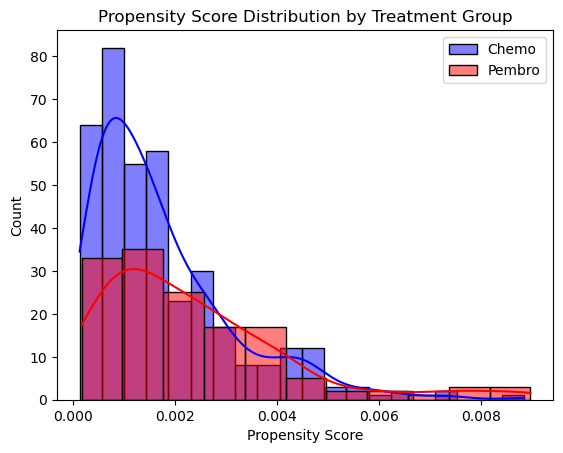

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(merged_df[merged_df['Cleaned_Regimen'] == 'carboplatin, pemetrexed, pembrolizumab']['propensity_score'], color='blue', label='Chemo', kde=True)
sns.histplot(merged_df[merged_df['Cleaned_Regimen'] == 'carboplatin, pemetrexed']['propensity_score'], color='red', label='Pembro', kde=True)
plt.title("Propensity Score Distribution by Treatment Group")
plt.xlabel("Propensity Score")
plt.ylabel("Count")
plt.legend()
plt.show()
